---
title: "Geocoding Postcodes in Python: pgeocode v ONS"
author: "Daniel Smith"
date: "2024-03-16"
categories: [Python, Pandas, Folium, Emmanuel House]
title-block-banner: false
jupyter: python3
image: 'ons_map.png'
draft: false
description: "I explain a problem encountered in voluntary work undertaken for Emmanuel House Support Centre in Nottingham related to encoding postcodes as coordinates, and the solution I found."
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import folium
import pgeocode

As part of my voluntary work for [Emmanuel House](https://www.emmanuelhouse.org.uk/), a Nottingham charity providing support and shelter for the homeless and vulnerably housed, I undertook a project studying the geographic distribution of individual donors to the charity across the UK.

In this post I illustrate an issue I encountered while attempting to encode the postcodes of individual donors as latitude and longitude pairs, and the solution I found.

The goal of encoding the postcodes was to produce visualisations showing how donors are distributed across Nottingham. This allowed us to gain insight into which areas/demographics should be targeted by marketing campaigns, and which social groups are underrepresented in Emmanuel House's donor database.

In [2]:
df = pd.read_csv('nottm_postcodes.csv')

`nottm_postcodes.csv` is a file I constructed consisting of 100 random postcodes within Nottingham city. 

**Importantly, these are not postcodes of real donors to the charity. Sharing such information online would violate GDPR. These postcodes are randomly selected from publicly available datasets**

In [3]:
df.head(10)

,Postcode
0,NG9 3WF
1,NG9 4WP
2,NG9 3EL
3,NG1 9FH
4,NG5 6QZ
5,NG7 5QL
6,NG7 2FT
7,NG4 1PY
8,NG8 3SL
9,NG9 4AX


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Postcode  100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [5]:
df.nunique()

Postcode    100
dtype: int64

In [6]:
postcodes = df['Postcode'].to_list()

# Geocoding with pgeocode

I first attempted to geocode the postcodes using [pgeocode](https://pypi.org/project/pgeocode/), a lightweight Python library for geocoding postcodes and distance calculations.

In [7]:
nomi = pgeocode.Nominatim('gb')

In [8]:
print('Querying postcode:', df.iloc[0]['Postcode'])
nomi.query_postal_code(df.iloc[0]['Postcode'])

Querying postcode: NG9 3WF


postal_code                                                     NG9
country_code                                                     GB
place_name        Bramcote, Beeston, Toton, Stapleford, Attenbor...
state_name                                                  England
state_code                                                      ENG
county_name                                         Nottinghamshire
county_code                                                11609044
community_name                                                  NaN
community_code                                                  NaN
latitude                                                   52.91914
longitude                                                  -1.24548
accuracy                                                        4.0
Name: 0, dtype: object

In [9]:
nomi.query_postal_code(postcodes)[['latitude','longitude']].head()

,latitude,longitude
0,52.91914,-1.24548
1,52.91914,-1.24548
2,52.91914,-1.24548
3,52.95360,-1.15050
4,53.00060,-1.13150


In [10]:
df[['Latitude','Longitude']] = nomi.query_postal_code(postcodes)[['latitude','longitude']]

In [11]:
df.head()

,Postcode,Latitude,Longitude
0,NG9 3WF,52.91914,-1.24548
1,NG9 4WP,52.91914,-1.24548
2,NG9 3EL,52.91914,-1.24548
3,NG1 9FH,52.95360,-1.15050
4,NG5 6QZ,53.00060,-1.13150


At a first glance it seems that pgeocode has provided an elegent solution to the problem in only a few lines of fast-running code. However upon closer inspection:

In [12]:
df[['Latitude','Longitude']].value_counts()

Latitude   Longitude
52.953600  -1.150500    42
52.929150  -1.114850    13
52.964800  -1.213200    12
52.919140  -1.245480    11
53.000600  -1.131500    10
52.998900  -1.197100     5
52.970960  -1.081000     3
52.878620  -1.195240     2
52.903579  -1.044274     1
52.952566  -0.894169     1
Name: count, dtype: int64

In [13]:
df[['Latitude','Longitude']].nunique()

Latitude     10
Longitude    10
dtype: int64

Despite `df` containing 100 unique postcodes, pgeocode has only encoded these into 10 different latitude, longitude pairs.

Whats worse is that 42(!!) distinct postcodes were each encoded into (52.953600,  -1.150500).

We can judge this approach by contructing a visualisation in the form as an interactive .html map using [Folium](https://pypi.org/project/folium/):

In [14]:
pgeocode_map = folium.Map(location=[52.9548, -1.1581], zoom_start=13)

for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
    ).add_to(pgeocode_map)

pgeocode_map.save("pgeocode_map.html")

Taking a screenshot of this map and displaying using matplotlib:

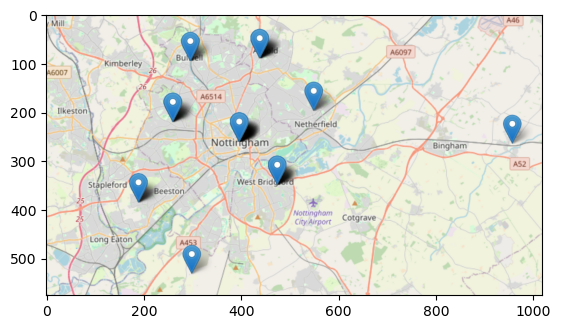

In [15]:
img = mpimg.imread('pgeocode_map.png')
imgplot = plt.imshow(img)
plt.show()

It indeed seems that pgeocode has encoded the postcodes with a less than desirable accuracy, resulting in large numbers of distinct postcodes being sent to the same point on the map.

In [16]:
df = df.drop(['Latitude', 'Longitude'], axis=1)

# Geocoding with ONS data

Upon suggestion from a friend I proceeded to directly encode the postcodes by downloading data from the Office for National Statistics (ONS) instead of relying on a Python library.

This had the advantage of resulting in a far more accurate geocoding, but had the disadvantage of being more computationally expensive.

In [17]:
post = pd.read_csv(r"C:\Users\Daniel\Downloads\open_postcode_geo.csv\open_postcode_geo.csv", header=None)
post = post[[0, 7, 8]]
post = post.rename({0: 'Postcode', 7: 'Latitude', 8: 'Longitude'}, axis=1)
post.sample(5)

,Postcode,Latitude,Longitude
910559,GU22 9PQ,51.304894,-0.559580
1770156,PL14 5HX,50.486283,-4.472293
1314452,M14 6AY,53.437343,-2.226147
2588679,WV16 5BP,52.533551,-2.427564
2260415,SW3 5DW,51.483789,-0.172505


`open_postcode_geo.csv` can be downloaded from [https://www.data.gov.uk/dataset/091feb1c-aea6-45c9-82bf-768a15c65307/open-postcode-geo](https://www.data.gov.uk/dataset/091feb1c-aea6-45c9-82bf-768a15c65307/open-postcode-geo) and is contructed from data made publicly available by the ONS.

`open_postcode_geo.csv` consists of over 2.6 million UK postcodes, along with their latitudes and longitudes. Other information about the postcodes is also included which is irrelevant for the purposes of this post.

Because of the length of the dataset the code cells in this section take some time to run.

In [18]:
len(post)

2631536

We can now geocode the postcodes in `df` by joining the corresponding Latitude and Longitude from `post`:

In [19]:
df = df.merge(post, on='Postcode', how='left')
df.head()

,Postcode,Latitude,Longitude
0,NG9 3WF,52.930121,-1.198353
1,NG9 4WP,52.921587,-1.247504
2,NG9 3EL,52.938985,-1.239510
3,NG1 9FH,52.955008,-1.141045
4,NG5 6QZ,52.996670,-1.106307


In [20]:
df[['Latitude', 'Longitude']].value_counts()

Latitude   Longitude
52.945107  -1.135586    8
52.955008  -1.141045    4
52.930121  -1.198353    3
52.955053  -1.141030    2
52.959917  -1.222127    2
                       ..
52.953058  -1.144924    1
52.952972  -1.228161    1
52.952828  -1.145360    1
52.952059  -1.170039    1
52.998288  -1.135252    1
Name: count, Length: 85, dtype: int64

In [21]:
df[['Latitude','Longitude']].nunique()

Latitude     85
Longitude    85
dtype: int64

This program has resulted in 85 unique latitude, longitude pairs. A significant improvement over the results from pgeocode.

Producing another visualisation using Folium:

In [22]:
ons_map = folium.Map(location=[52.9548, -1.1581], zoom_start=13)

for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
    ).add_to(ons_map)

ons_map.save("ons_map.html")

Taking a screenshot of the map using ShareX and displaying using matplotlib:

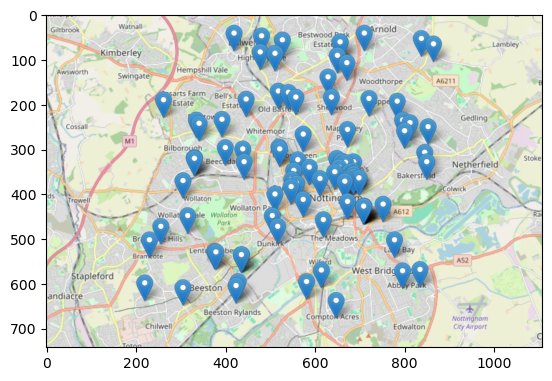

In [23]:
img = mpimg.imread('ons_map.png')
imgplot = plt.imshow(img)
plt.show()

This looks significantly more realistic than the map produced using pgeocode to geocode.